#  Assignment-2B-Task2_flight_consumer: Consuming data using Kafka (10%)

Name : Pichaphop Sunthornjittanon

Student ID : 31258301

In this task, we will implement multiple Apache Kafka consumers to consume the
data from task 1.


Important:
- In this task, use Kafka consumer to consume the data from task 1.
- Do not use Spark in this task
Event Flight Consumer


Write a python program that consumes the process events using kafka consumer,
visualising the countFlightRecords in real time based on the timestamp. Save the file
as Assignment-2B-Task2_flight_consumer.ipynb.
Your program should get the count of countFlightRecords captured by the consumer
in the last 2-minutes (use the processing time) for each keyFlight. For this, print the
number of flights for keyFlight = ‘1’, keyFlight = ‘2’, and keyFlight = ‘3’ only. Then,
use line charts to visualize it. Note, in this task, please use ts as timestamp generated
from producer step (disregard DAY, DAY_OF_WEEK, MONTH, and YEAR as the
real timestamp)


● Hint - x-axis can be used to represent the timestamp, while y-axis can be used
to represent the number of countFlightRecords data can be represented in
different color legends.

<IPython.core.display.Javascript object>


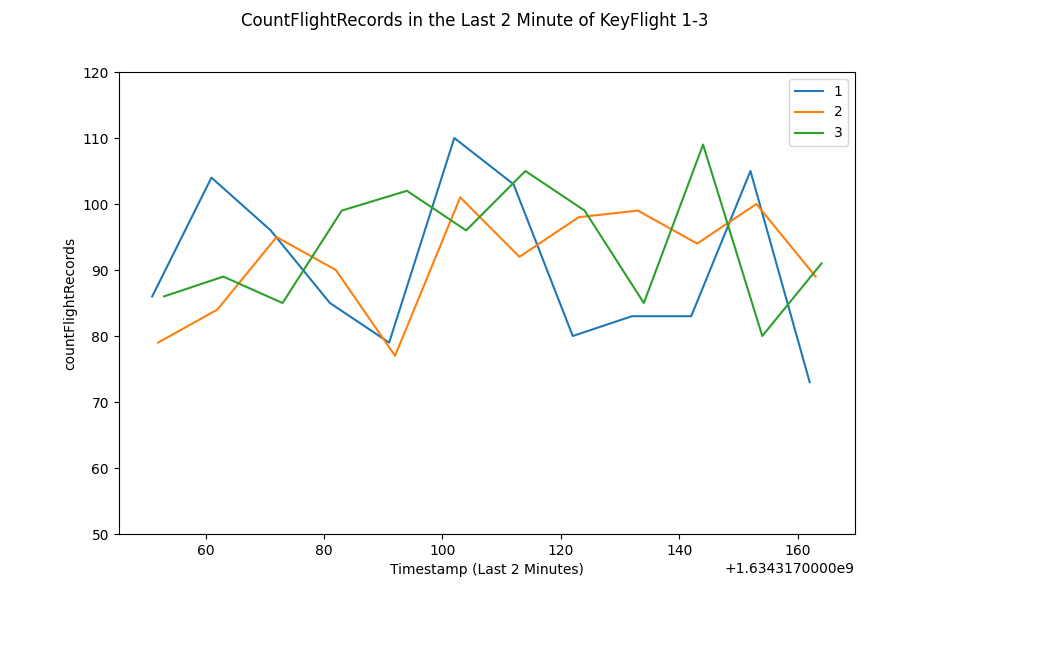

KeyboardInterrupt: 

In [2]:
# import statements
from time import sleep
from kafka import KafkaConsumer
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
from json import loads
import pandas as pd

# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

topic = 'flightTopic'

def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
                                   auto_offset_reset='latest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['localhost:9092'],
                                   value_deserializer=lambda x: loads(x.decode('ascii')),
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('CountFlightRecords in the Last 2 Minute of KeyFlight 1-3') # giving figure a title
        ax.set_xlabel('Timestamp (Last 2 Minutes)')
        ax.set_ylabel('countFlightRecords')        
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))


def consume_messages(consumer, fig, ax):
    try:

        
        flight_df = pd.DataFrame()
        for message in consumer:   
            
            #
            new_data = message.value
            
            # Convert data to incoming data to dataframe
            new_data_df = pd.DataFrame(new_data)
            
            # Append to the current dataframe
            flight_df= pd.concat([flight_df, new_data_df])
            
            # Filter data that is not in 2 minutes and only day of week (keyFlight) in 1,2,3
            filter_con =(flight_df['ts'] >= flight_df['ts'].max() - 120) & (flight_df['DAY_OF_WEEK'].isin([1,2,3]))
            flight_df_select = flight_df.loc[filter_con,['ts','DAY_OF_WEEK','FLIGHT_NUMBER']]   
            
            
            # Count flight records Group by timestamp and day of week
            flight_df_group = flight_df_select.groupby(['ts','DAY_OF_WEEK']).count().reset_index()
            
            # Clear axis
            ax.clear()
            
            # For each keyFlight
            for keyFlight in [1,2,3]:
                
                # Plot each line for each keyFlight where X axis = Timestamp, Y = countFlightRecords
                ax.plot(flight_df_group[flight_df_group.DAY_OF_WEEK==keyFlight].ts
                        ,flight_df_group[flight_df_group.DAY_OF_WEEK==keyFlight].FLIGHT_NUMBER
                        ,label=keyFlight)
                
            # Graph setting                    
            ax.set_xlabel('Timestamp (Last 2 Minutes)')
            ax.set_ylabel('countFlightRecords')
            ax.set_ylim(50,120) 
            ax.set_yticks([50,60,70,80,90,100,110,120])
            ax.legend(loc='best')
            fig.canvas.draw()

    except Exception as ex:
        print(str(ex))
    
if __name__ == '__main__':
    
    # Connect to Kafka consumer
    consumer = connect_kafka_consumer()
    
    # Initialise plot
    fig, ax = init_plots()    
    
    # Consume messange and plot the real-time line charts
    consume_messages(consumer, fig, ax)        
    